# Caso studio "embarrassingly parallel"
## L'insieme di Mandelbrot
A tutti piaccioni i frattali, giusto? L'insieme di Mandelbrot è probabilmente il più famoso di questi oggetti. La parola *frattale* su introdotta da B. Mandelbrot, che nel 1980 scoprì l'omonimo insieme. I frattali sono, intuitivamente, delle figure il cui motivo si ripete uguale a se stesso su scale diversa: questa proprietà in matematica prende il nome di autosimilarità. 

L'insieme di Mandelbrot può essere descritto da una semplice formula ricorsiva: appartengono a questo insieme tutti i punti $c$ del piano complesso per i quali la successione
$$ z_0 = c, \quad z_{n+1} = z_n^2 + c. $$
rimane limitata.
Per visualizzare questo insieme, consideriamo un sottoinsieme $[x_{min}, x_{max}] \times [y_{min}, y_{max}]$ del piano cartesiano e scegliamo una sua discretizzazione a seconda delle dimensioni dell'immagine che vogliamo otterene. Per ciascun punto $(x,y)$, definiamo $c = x + iy$ e ne calcoliamo la successione $z_n$. 
Ovviamente è impossibile calcolare la successione infinita $z_n$, quello che si fa è calcolare la successione finché $|z_n|$ non eccede un certo valore (è possibile dimostrare che se $|z_n| > 2$ allora la successione diverge) oppure finché $n$ non raggiunge un numero massimo di iterazioni $maxit$. In entrambi i casi vogliamo salvare l'intero $n$. Ogni pixel sarà colorato in base a quanto velocemente la successione diverge.

**L'algoritmo seriale**
1. for $x$ from $x_{min}$ to $x_{max}$ do 
2. $\quad$ for $y$ from $y_{min}$ to $y_{max}$ do
3. $\qquad$ $c = x+iy$
4. $\qquad$ $z = 0+i0$
4. $\qquad$ $i=0$
5. $\qquad$ while $i < maxit$ and $z*z < 4$ do
6. $\qquad \qquad$ $z = z*z + c$
7. $\qquad \qquad$ $i=i+1$
9. $\qquad$ end while 
10. $\quad$ end for
11. end for

In [1]:
import numpy as np

import numba
from numba import cuda

import math

import time
from timeit import timeit, default_timer

from matplotlib import pyplot as plt
#from matplotlib import colors
%matplotlib inline

In [2]:
def mandelbrot(z,maxiter):
    c = z
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        #endif
        z = z*z + c
    #endfor
    return maxiter

def mandelbrot_set(xmin,xmax,ymin,ymax,img_width,img_height,maxiter):
    x = np.linspace(xmin, xmax, img_width)
    y = np.linspace(ymin, ymax, img_height)
    n = np.empty((img_width,img_height))
    for i in range(img_width):
        for j in range(img_height):
            n[i,j] = mandelbrot(x[i] + 1j*y[j] ,maxiter)
        #endfor
    #endfor
    return n

In [3]:
def mandelbrot_image(img, xmin, xmax, ymin, ymax):
    dpi = 72
    width  = img.shape[0] / dpi 
    height = img.shape[1] / dpi
    
    fig, ax = plt.subplots(figsize=(width, height), dpi = 72)
    ax.imshow(img.T, extent=[xmin, xmax, ymin, ymax])
    
    return

In [4]:
xmin = -1.78
xmax =  0.78
ymin = -0.961
ymax =  0.961
img_width  = 1024
img_height = 768
maxiter = 100

t_i = default_timer()
img_cpu = mandelbrot_set(xmin,xmax,ymin,ymax,img_width,img_height,maxiter)
t_f = default_timer()
print("Tempo di esecuzione = ", t_f - t_i, "s")

Tempo di esecuzione =  13.938455281313509 s


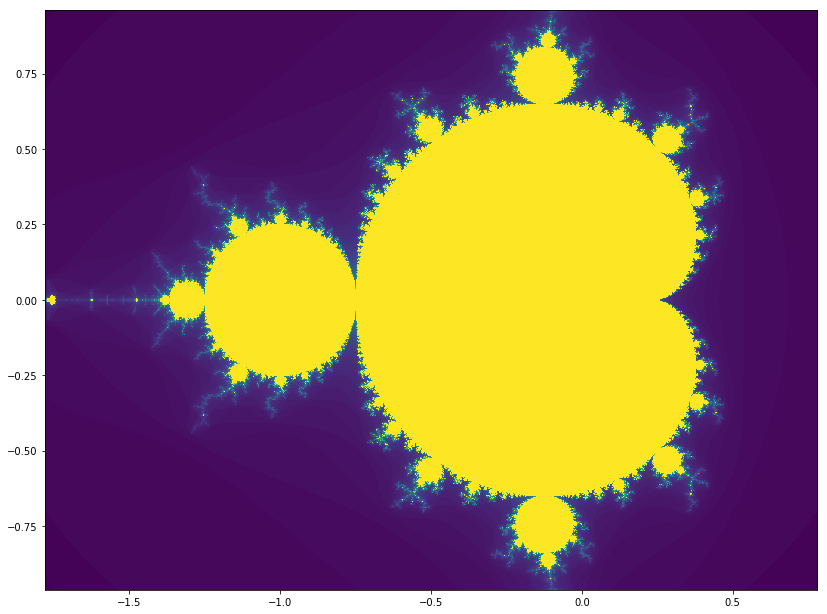

In [5]:
mandelbrot_image(img_cpu, xmin, xmax, ymin, ymax)

Se guardiamo l'algoritmo seriale sopra presentato, è chiaro che la rappresentazione grafica dell'insieme di Mandelbrot è un'applicazione altamente parallela: infatti, il calcolo del colore di ogni pixel è completamente indipendente dagli altri. Questa proprietà ci permette di suddividere l'immagine totale in unità di lavoro o *task* indipendenti, dove un *task* è una porzione di immagine arbitrariamente piccola (almeno un pixel). Nel linguaggio del calcolo parallelo diciamo che l'applicazione è *embarrassingly parallel*, che vuol dire che non ci sono inter-dipendenze.

La rappresentazione dell'insieme di Mandelbrot è anche un'applicazione *irregolare*: infatti il numero di iterazioni necessario per determinare se la successione diverge o meno è diverso per ogni pixel ed non è noto a priori. Per mostrare graficamente questa proprietà misuriamo i tempi di calcolo per costruire una riga dell'immagine su CPU, modificando la funzione **mandelbrot_set**.

In [6]:
def mandelbrot_set(xmin,xmax,ymin,ymax,img_width,img_height,maxiter):
    x = np.linspace(xmin, xmax, img_width)
    y = np.linspace(ymin, ymax, img_height)
    n = np.empty((img_width,img_height))
    exec_time = np.empty((img_height,))
    for j in range(img_height):
        t_i = time.time()
        for i in range(img_width):
            n[i,j] = mandelbrot(x[i] + 1j*y[j] ,maxiter)
        #endfor
        t_f = time.time()
        exec_time[j] = t_f - t_i
    #endfor
    return exec_time, n

exec_time, img_cpu = mandelbrot_set(xmin,xmax,ymin,ymax,img_width,img_height,maxiter)

Text(0.5,0,'Righe')

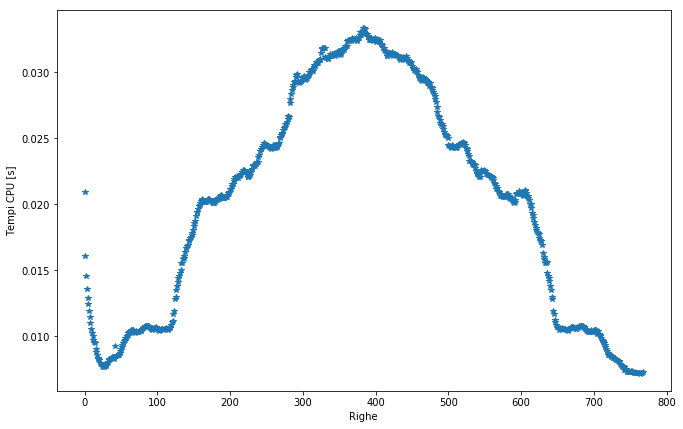

In [7]:
plt.figure(figsize=(11,7))
plt.plot(exec_time, '*')
plt.ylabel('Tempi CPU [s]')
plt.xlabel('Righe')

La figura sopra mostra chiaramente che la quantità di lavoro non è equidistribuita: le righe centrali richiedono molto più tempo delle righe in alto o in basso. Perciò è cruciale scegliere la distribuzione del lavoro in maniera tale da rendere l'implementazione il più bilanciata possibile (*load balance*).

In [9]:
@cuda.jit()
def mandelbrot_set_gpu(xmin,xmax,ymin,ymax,img,maxiter):
    pos_x, pos_y = cuda.grid(2)
    
    if (pos_x < img.shape[0]) and (pos_y < img.shape[1]):
        x = xmin + (xmax - xmin)/img_width*pos_x
        y = ymin + (ymax - ymin)/img_height*pos_y
        z = x + 1j*y
        c = z
    
        for n in range(maxiter):
            if abs(z) > 2:
                break
            #endif
            z = z*z + c
            img[pos_x,pos_y] = n
        #endfor
    return 

In [10]:
img_gpu = np.empty((img_width,img_height))

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(img_gpu.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(img_gpu.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

t_i = default_timer()
mandelbrot_set_gpu[blockspergrid, threadsperblock](xmin,xmax,ymin,ymax,img_gpu,maxiter)
t_f = default_timer()
print("Tempo di esecuzione = ", t_f - t_i, "s")

Tempo di esecuzione =  0.24847765918821096 s


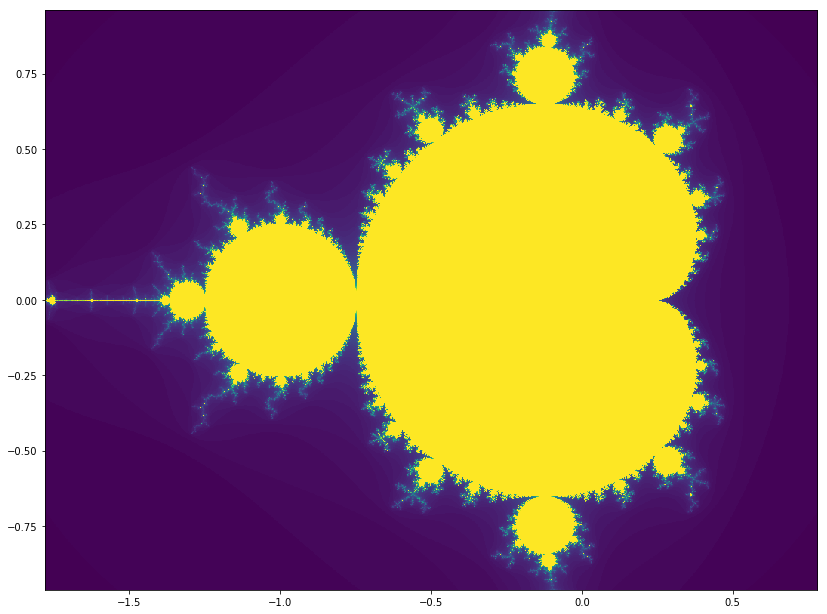

In [11]:
mandelbrot_image(img_gpu, xmin, xmax, ymin, ymax)

Quant'è lo speedup ottenuto? 

Vediamo coma succede se effettuiamo il calcolo allocando la memoria sulla GPU:

In [12]:
d_img_gpu = cuda.to_device(img_gpu)

t_i = default_timer()
mandelbrot_set_gpu[blockspergrid, threadsperblock](xmin,xmax,ymin,ymax,d_img_gpu,maxiter)
t_f = default_timer()

d_img_gpu.copy_to_host(img_gpu)
del d_img_gpu
print("Tempo di esecuzione = ", t_f - t_i, "s")

Tempo di esecuzione =  0.24650459084659815 s


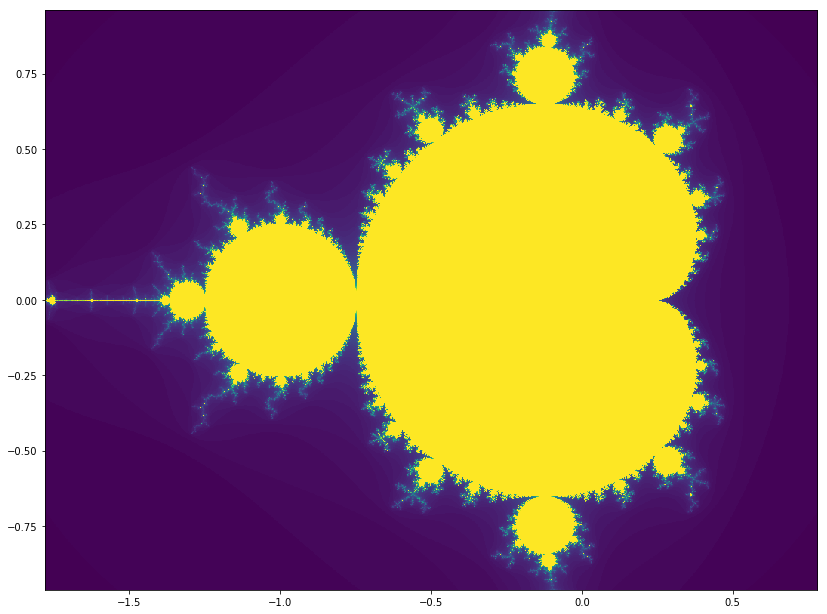

In [13]:
mandelbrot_image(img_gpu, xmin, xmax, ymin, ymax)

Quant'è lo speedup ottenuto? Notate differenze dall'esecuzione precedente?